### Building a Better (and More Realistic) Momentum Strategy
Real-world quantitative investment firms differentiate between "high quality" and "low quality" momentum stocks:
* High-quality momentum stocks show "slow and steady" outperformance over long periods of time
    - Suppose A stock show consistant perform even small (0.5% or 1%) consider hqm 
* Low-quality momentum stocks might not show any momentum for a long time, and then surge upwards.
    - A stock which shows sudden or some month higher return (e.g. 10%) and remaning month lower 
----
The reason why high-quality momentum stocks are preferred is because low-quality momentum can often be cause by `short-term news` that is unlikely to be repeated in the future (such as an FDA approval for a biotechnology company).
To identify high-quality momentum, we're going to build a strategy that selects stocks from the highest percentile
* 1-month price returns
* 3-month price returns
* 6-month price returns
* 1-year price returns

Let's start by building our DataFrame. You'll notice that I use the abbreviation hqm often. It stands for high-quality-momentum stocks.



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf 
import talib
import datetime as dt
from scipy.stats import percentileofscore as score

In [176]:
import pandas as pd
import numpy as np
from dataclasses import dataclass

@dataclass
class HQM:
    df: pd.DataFrame
    portfolio_value: float = 100000
    required_col = [
        'One Year Return', 
        'Six Month Return', 
        'Three Month Return', 
        'One Month Return'
    ]

    def _get_null_value(self) -> pd.DataFrame:
        return self.df.isnull().sum()

    def get_stock_stats(self) -> pd.DataFrame:
        null_values = self._get_null_value()
        if null_values.sum() == 0:
            position_size = self.portfolio_value / len(self.df)
            # floor division operator - to get the whole number of share
            number_of_share_to_buy = (position_size // self.df.iloc[-1]).astype('int64')
            
            # Store the changes in the dataframe
            changes = {}
            periods = {
                'year5': 252 * 5,
                'year3': 252 * 3,
                'year2': 252 * 2,
                'year1': 252,
                'month6': 21 * 6,
                'month3': 21 * 3,
                'month1': 21,
                'day30': 30,
                'day5': 5
            }
            
            max_value = self.df.max()
            min_value = self.df.min()
            latest_price = self.df.iloc[-1]
            changes['maxChanges'] = ((max_value - min_value ) / min_value) * 100
            
            for period_name, period_number in periods.items():
                #  Validating : If the period number is greater than the length of the dataframe, continue
                if period_number >= len(self.df):
                    continue
                past_price = self.df.iloc[-period_number]
                changes[f"{period_name}ChangePercentage"] = (latest_price - past_price) / past_price * 100

            dataframe = pd.DataFrame.from_dict(changes)
            dataframe['latest Price'] = latest_price
            dataframe['Number of Shares to buy'] = number_of_share_to_buy
            
            return dataframe
        else:
            print(f'Null values found in: {null_values[null_values > 0]}')

    def get_momentum_data(self) -> pd.DataFrame:
        df = self.get_stock_stats()
        
        new_df = pd.DataFrame()
        new_df_col = ['latest Price', 'Number of Shares to buy', 'year1ChangePercentage', 'month6ChangePercentage', 'month3ChangePercentage', 'month1ChangePercentage']
        
        for col in new_df_col:
            if col in df.columns:
                new_df[col] = df[col]
                if col not in ['latest Price', 'Number of Shares to buy']:
                    new_df[f'{col}Percentile'] = np.nan
            else:
                new_df[col] = np.nan
        
        update_col = ['latest Price', 'Number of Shares to buy', 'One Year Return', 'One Year Return Percentile', 'Six Month Return', 
                      'Six Month Return Percentile', 'Three Month Return', 'Three Month Return Percentile', 
                      'One Month Return', 'One Month Return Percentile']
        
        new_df.columns = update_col
        
        for col in self.required_col:
            changed_col = col 
            percentile_col = f'{col} Percentile'
            new_df[percentile_col] = new_df[changed_col].rank(pct=True)
        
        return new_df

    def get_hqm_score(self) -> pd.DataFrame:
        df = self.get_momentum_data()
        df['HQM Score'] = df[[f'{col} Percentile' for col in self.required_col]].mean(axis=1)
        return df


In [180]:
ticker_list =  ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'JPM', 'BAC', 'V', 'MA', 'PG', 'KO', 'WMT', 'PEP', 'JNJ', 'UNH', 'PFE','LLY']
crypto_list = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD', 'BCH-USD', 'XMR-USD', 'ADA-USD', 'DASH-USD', 'ETC-USD', 'ZEC-USD', 'XLM-USD', 'DOGE-USD']

In [178]:
stock_df = yf.download(ticker_list, start='2020-01-01', end=dt.date.today(), interval='1D')['Adj Close']
stockobj = HQM(stock_df).get_hqm_score()
stockobj

[*********************100%%**********************]  17 of 17 completed


,latest Price,Number of Shares to buy,One Year Return,One Year Return Percentile,Six Month Return,Six Month Return Percentile,Three Month Return,Three Month Return Percentile,One Month Return,One Month Return Percentile,HQM Score
Ticker,,,,,,,,,,,
AAPL,208.139999,0,12.087729,0.411765,7.195544,0.411765,21.991395,1.000000,11.376281,1.000000,0.705882
AMZN,185.570007,0,43.485660,0.764706,20.625333,0.764706,3.260809,0.411765,2.496550,0.529412,0.617647
BAC,40.020000,2,48.508997,0.941176,22.129623,0.823529,9.233332,0.764706,2.791447,0.588235,0.779412
GOOG,180.789993,0,47.127076,0.882353,27.641552,0.882353,19.745764,0.941176,3.390685,0.647059,0.838235
JNJ,149.119995,0,-7.065342,0.176471,-2.178528,0.176471,-3.153337,0.117647,-0.387443,0.235294,0.176471
JPM,198.880005,0,47.030058,0.823529,20.163349,0.647059,2.679444,0.352941,0.995331,0.352941,0.544118
KO,63.970001,1,7.874347,0.352941,12.057274,0.529412,6.732395,0.705882,3.827295,0.705882,0.573529
LLY,890.109985,0,95.440369,1.000000,56.152106,1.000000,15.325444,0.882353,10.100807,0.941176,0.955882
MA,456.959991,0,21.019009,0.529412,8.235908,0.470588,-3.875112,0.058824,1.274351,0.411765,0.367647


In [181]:
crypto_df = yf.download(crypto_list, start='2020-01-01', end=dt.date.today(), interval='1D')['Adj Close']
cryptoobj = HQM(crypto_df).get_hqm_score()
cryptoobj

[*********************100%%**********************]  12 of 12 completed


,latest Price,Number of Shares to buy,One Year Return,One Year Return Percentile,Six Month Return,Six Month Return Percentile,Three Month Return,Three Month Return Percentile,One Month Return,One Month Return Percentile,HQM Score
Ticker,,,,,,,,,,,
ADA-USD,0.377765,161,52.870120,0.583333,-39.282186,0.083333,-24.476602,0.333333,-18.141434,0.500000,0.375000
BCH-USD,363.948273,0,60.475088,0.750000,37.098309,0.916667,-27.993221,0.083333,-23.715496,0.250000,0.500000
BTC-USD,60277.414062,0,112.126790,0.916667,15.286522,0.750000,-9.230705,0.833333,-14.582227,0.750000,0.812500
DASH-USD,23.120350,2,-7.592676,0.250000,-22.561508,0.250000,-26.034907,0.166667,-22.899143,0.333333,0.250000
DOGE-USD,0.119043,513,101.358256,0.833333,38.192305,1.000000,-25.572074,0.250000,-26.266336,0.166667,0.562500
ETC-USD,22.987734,2,53.635113,0.666667,-15.036136,0.500000,-18.352319,0.500000,-22.697259,0.416667,0.520833
ETH-USD,3350.256348,0,114.013776,1.000000,11.174789,0.666667,4.048084,0.916667,-12.124789,0.833333,0.854167
LTC-USD,69.689819,0,12.108181,0.500000,0.049749,0.583333,-18.116020,0.583333,-16.694233,0.583333,0.562500
XLM-USD,0.089236,684,-13.453014,0.166667,-24.177075,0.166667,-23.995605,0.416667,-16.154435,0.666667,0.354167


In [182]:
cryptoobj.sort_values(by='HQM Score', ascending=False)

,latest Price,Number of Shares to buy,One Year Return,One Year Return Percentile,Six Month Return,Six Month Return Percentile,Three Month Return,Three Month Return Percentile,One Month Return,One Month Return Percentile,HQM Score
Ticker,,,,,,,,,,,
ETH-USD,3350.256348,0,114.013776,1.000000,11.174789,0.666667,4.048084,0.916667,-12.124789,0.833333,0.854167
BTC-USD,60277.414062,0,112.126790,0.916667,15.286522,0.750000,-9.230705,0.833333,-14.582227,0.750000,0.812500
XMR-USD,159.021805,0,5.646219,0.416667,28.417747,0.833333,30.933489,1.000000,-0.582056,1.000000,0.812500
XRP-USD,0.474143,128,-3.569497,0.333333,-15.771102,0.416667,-13.026656,0.750000,-9.818456,0.916667,0.604167
LTC-USD,69.689819,0,12.108181,0.500000,0.049749,0.583333,-18.116020,0.583333,-16.694233,0.583333,0.562500
DOGE-USD,0.119043,513,101.358256,0.833333,38.192305,1.000000,-25.572074,0.250000,-26.266336,0.166667,0.562500
ETC-USD,22.987734,2,53.635113,0.666667,-15.036136,0.500000,-18.352319,0.500000,-22.697259,0.416667,0.520833
BCH-USD,363.948273,0,60.475088,0.750000,37.098309,0.916667,-27.993221,0.083333,-23.715496,0.250000,0.500000
ADA-USD,0.377765,161,52.870120,0.583333,-39.282186,0.083333,-24.476602,0.333333,-18.141434,0.500000,0.375000


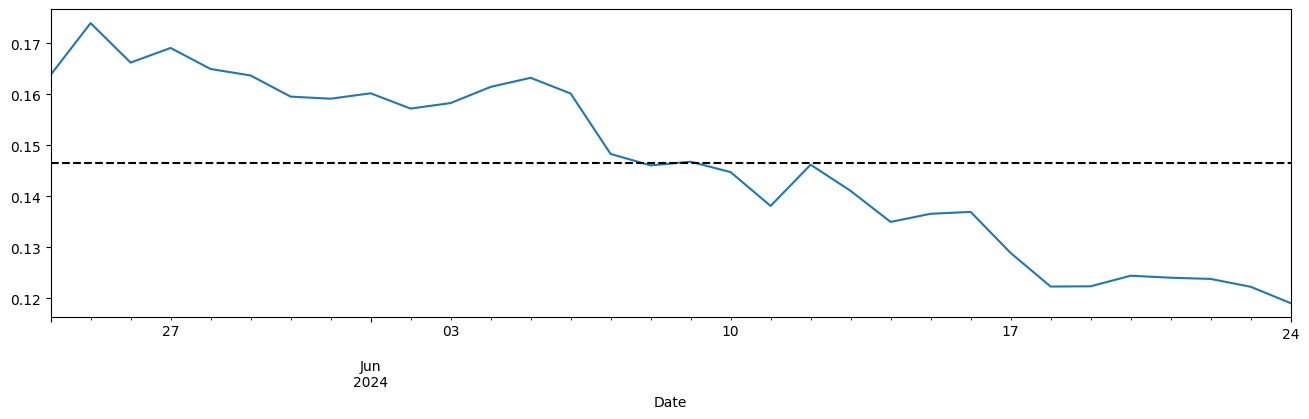

In [206]:
crypto_df.loc['2024-05-24':, 'DOGE-USD'].plot(figsize=(16,4))
plt.axhline(y=crypto_df.loc['2024-05-24':, 'DOGE-USD'].mean(), color='black', linestyle='--')

In [204]:
cryptoobj = HQM(crypto_df).get_stock_stats()

In [205]:
cryptoobj

,maxChanges,year5ChangePercentage,year3ChangePercentage,year2ChangePercentage,year1ChangePercentage,month6ChangePercentage,month3ChangePercentage,month1ChangePercentage,day30ChangePercentage,day5ChangePercentage,latest Price,Number of Shares to buy
Ticker,,,,,,,,,,,,
ADA-USD,12287.792876,31.624055,-39.582151,-5.371861,52.870120,-39.282186,-24.476602,-18.141434,-17.586039,-1.686167,0.377765,161
BCH-USD,1626.238529,-19.172838,78.706745,167.669628,60.475088,37.098309,-27.993221,-23.715496,-24.799638,-6.646883,363.948273,0
BTC-USD,1370.259821,77.689130,89.597462,159.098436,112.126790,15.286522,-9.230705,-14.582227,-12.027012,-7.020417,60277.414062,0
DASH-USD,1808.931930,-81.924834,-64.199041,-64.845796,-7.592676,-22.561508,-26.034907,-22.899143,-22.450942,-1.911436,23.120350,2
DOGE-USD,44452.833160,1376.410821,38.639728,28.589487,101.358256,38.192305,-25.572074,-26.266336,-28.382262,-4.320886,0.119043,513
ETC-USD,3283.037707,227.987667,-3.233415,-0.918365,53.635113,-15.036136,-18.352319,-22.697259,-27.522159,-4.411567,22.987734,2
ETH-USD,4250.661739,221.079677,72.486642,100.373759,114.013776,11.174789,4.048084,-12.124789,-12.432145,-4.580649,3350.256348,0
LTC-USD,1149.401028,-47.457804,1.868746,-30.950727,12.108181,0.049749,-18.116020,-16.694233,-16.936971,-6.718012,69.689819,0
XLM-USD,2082.937210,-68.327163,-40.583802,-3.020159,-13.453014,-24.177075,-23.995605,-16.154435,-17.895590,-4.980139,0.089236,684
